# Traffic Signs Classification
Here i'm gonna be trying to classify traffic signs from crops that are going to be coming for a YOLO detector, since YOLO doesn't have much accuracy, but it detects traffic signs, I'm going to take the bounding box from YOLO, crop the image, and pass it through this classifier.

Let's see if it actually works **;)**

If you want to skip the set-up go to the [Model-4](#Model-4) section.

In [6]:
import os
import cv2
import csv
import glob
import pickle
import random
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from models.cnn_models import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [7]:
# Data path
data_path = 'data/maxspeed/'

# Pickle files
train_pickle_file = 'train.p' 

In [8]:
# Load train data
train_file = open(os.path.join(data_path, train_pickle_file), 'rb')
train_data = pickle.load(train_file)

In [9]:
# Data shapes
print('Train data shape:', train_data.shape)

Train data shape: (6240, 2)


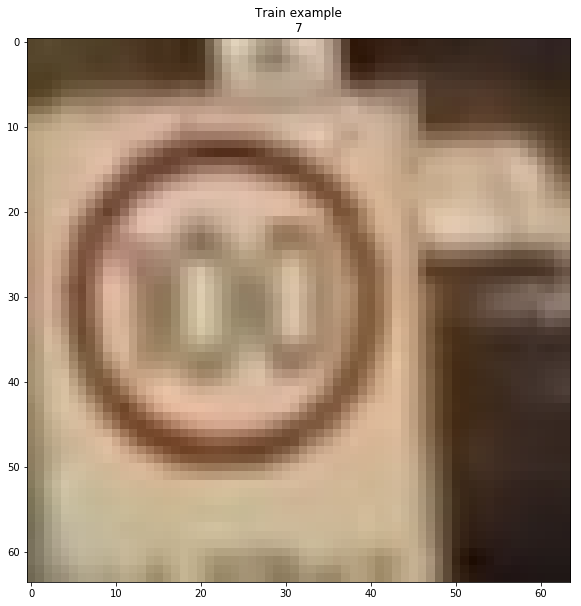

In [10]:
# Verify data
index = random.randrange(0, len(train_data))
plt.imshow(train_data[index][0])
plt.title('Train example\n' + str(train_data[index][1]))

plt.show()

In [11]:
# Organize data
x_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])

In [12]:
x_train.shape

(6240, 64, 64, 3)

In [13]:
y_train.shape

(6240,)

In [14]:
# Make RGB values between 0 and 1
x_train = x_train.astype('float32')
x_train /= 255

In [15]:
# Convert labels to one hot encoding
y_train = keras.utils.to_categorical(y_train, 11)

# Image Data Generator

In [16]:
datagen = ImageDataGenerator(rotation_range=5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.05,
                             zoom_range=0.05)

In [17]:
print(x_train.shape)
print(y_train.shape)

(6240, 64, 64, 3)
(6240, 11)


In [18]:
datagen.fit(x_train)

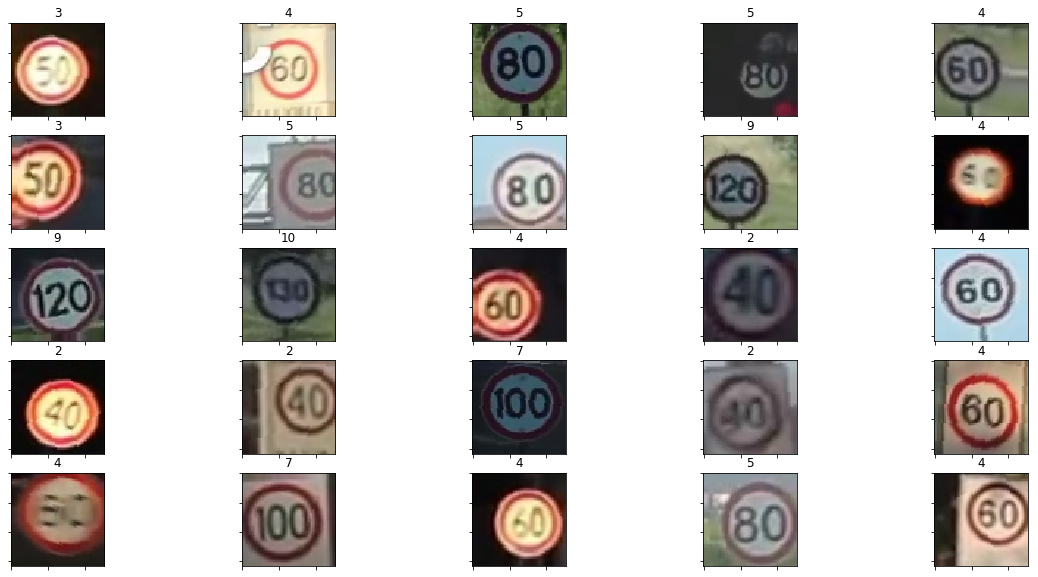

In [19]:
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
    # create a grid of 3x3 images
    for i in range(0, 25):
        plt.subplot(5, 5, 0 + 1 + i)
        plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        plt.gca().set_yticklabels([])
        plt.gca().set_xticklabels([])
        class_id = np.argmax(y_batch[i])
        plt.title(class_id)
    plt.show()
    break

# Model 4
For this second try, I'm going to be trying the VGG16 architecture from [here](https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py). 

In this case, I'm using a *sigmoid* activation in the output layer, to see if I can put a threshold for traffic signs that are misclassified.

In [20]:
# Checkpoint path
checkpoint_path = 'checkpoints/'

# Model name
model_name = 'maxspeed'

In [21]:
model = max_speed()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 34, 34, 64)        0         
__________

In [32]:
# Define model parameters
BATCH_SIZE = 64
EPOCHS = 64

In [33]:
samples_per_epochs = len(x_train)
steps_per_epochs = int(samples_per_epochs/BATCH_SIZE)

In [34]:
# Callbacks
filepath = model_name + '-weights-{epoch:02d}-{acc:.2f}.hdf5'
folder = os.path.join(checkpoint_path, model_name)
filepath = os.path.join(folder, filepath)

callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='acc', 
                                                verbose=0, 
                                                save_best_only=False, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                period=1),
                keras.callbacks.TensorBoard(log_dir='./logs/7/', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=False, 
                                            embeddings_freq=0, 
                                            embeddings_layer_names=None, 
                                            embeddings_metadata=None)
            ]

In [35]:
# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
# Fit model with data generator
model.fit_generator(datagen.flow(x_train, y_train), 
                    steps_per_epoch=steps_per_epochs,
                    epochs=EPOCHS,
                    #validation_data=(x_valid, y_valid),
                    callbacks=callbacks)

Epoch 1/64
97/97 [==============================] - 6s - loss: 0.9614 - acc: 0.5954      

KeyboardInterrupt: 

In [ ]:
# Evaluate model
file_filter = '*.hdf5'
weights_files = glob.glob(os.path.join(folder, file_filter))
weights_files = sorted(weights_files)

print('Weights files count:', len(weights_files))

data = {}

In [ ]:
for weight_file in tqdm_notebook(weights_files):
    # Load weights
    model = model_4(weight_file)
    
    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Evaluate model
    score = model.evaluate(x_test, y_test, verbose=0)
    
    data[weight_file] = {'test_loss': score[0], 'test_acc': score[1]}

In [ ]:
max_acc = 0
max_acc_weights = None

for key in data.keys():
    if data[key]['test_acc'] > max_acc:
        max_acc = data[key]['test_acc']
        max_acc_weights = key

In [ ]:
print(max_acc, max_acc_weights)

In [ ]:
# Test on external image
image_path = 'data/images/1.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]

# Predict label for external test image
img_test = np.expand_dims(img, axis=0)
predictions = model.predict(img_test)

class_id = np.argmax(predictions)
class_label = classes[str(class_id)]

# Plot image with class label
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(img)
ax.set_title('Prediction -> ' + class_label, fontweight="bold")
plt.show()

In [ ]:
import time

# Test on external image
image_path = 'data/images/1.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]

# Predict label for external test image
img_test = np.expand_dims(img, axis=0)

start = time.time()

predictions = model.predict(img_test)
class_id = np.argmax(predictions)
class_label = classes[str(class_id)]

end = time.time()

elapsed = end - start

print('Predicted', class_label, 'in', elapsed, 'seconds.')